# Xavier
### Normal initialization
\begin{align}
W ∼ N(0, Var(W)) \\
Var(W) = \sqrt{\frac{2} {n_{in} + n_{out}}} \\
\end{align}

### Uniform initialization
\begin{align}
W ∼ U \Bigl(-\sqrt{\frac{6} {n_{in} + n_{out}}}, +\sqrt{\frac{6} {n_{in} + n_{out}}}\Bigr)
\end{align}

# He
### Normal initialization
\begin{align}
W ∼ N(0, Var(W) ) \\
Var(W) = \sqrt{\frac{2} {n_{in} }}\\
\end{align}

### Uniform initialization
\begin{align}
W ∼ U \Bigl(-\sqrt{\frac{6} {n_{in}}}, +\sqrt{\frac{6} {n_{in}}}\Bigr)
\end{align}

## MNIST dataset with Xavier initializtion

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
nb_epochs = 30
batch_size = 100

In [4]:
mnist_train = dsets.MNIST(root="../_datasets/", # 파일의 위치
                          train=True, # 학습 데이터 여부
                          transform=transforms.ToTensor(), # 데이터의 순서를 이미지에서 텐서에 맞도록 변환
                                                           # 일반 이미지 : 값 0~255, 순서 Height, Weight, Channel
                                                           # 변환된 이미지 : 값 0~1, 순서 Channel, Height, Weight
                          download=True)                   # 데이터가 없는 경우 다운을 받음
mnist_test = dsets.MNIST(root="../_datasets/", 
                          train=False, 
                          transform=transforms.ToTensor(),
                          download=True)

In [5]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,   # 무작위로 로딩 순서를 변경함
                                          drop_last=True) # 배치 사이즈보다 적은 마지막 부분의 데이터는 사용하지 않음

In [6]:
# nn layers
linear1 = torch.nn.Linear(28*28, 512, bias=True).to(device)
linear2 = torch.nn.Linear(512, 512, bias=True).to(device)
linear3 = torch.nn.Linear(512, 256, bias=True).to(device)
linear4 = torch.nn.Linear(256, 256, bias=True).to(device)
linear5 = torch.nn.Linear(256, 10, bias=True).to(device)
relu = torch.nn.ReLU()

# xavier initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

# model
model = torch.nn.Sequential(linear1, relu,
                            linear2, relu,
                            linear3, relu,
                            linear4, relu,
                            linear5).to(device)

# loss function & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(data_loader)
    
    for x, y in data_loader:
        x = x.view(-1, 28*28).to(device)
        y = y.to(device)

        hypothesis = model(x)
        cost = criterion(hypothesis, y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    print('Epoch: {:4}, Cost: {:.9f}'.format(epoch, avg_cost))
print('Learning finished')

Epoch:    0, Cost: 0.215646341
Epoch:    1, Cost: 0.087483294
Epoch:    2, Cost: 0.061977185
Epoch:    3, Cost: 0.044967335
Epoch:    4, Cost: 0.040860817
Epoch:    5, Cost: 0.031287607
Epoch:    6, Cost: 0.029875366
Epoch:    7, Cost: 0.025426196
Epoch:    8, Cost: 0.019964252
Epoch:    9, Cost: 0.021608196
Epoch:   10, Cost: 0.020932900
Epoch:   11, Cost: 0.014385705
Epoch:   12, Cost: 0.013950539
Epoch:   13, Cost: 0.015542871
Epoch:   14, Cost: 0.015787523
Epoch:   15, Cost: 0.013775410
Epoch:   16, Cost: 0.009880080
Epoch:   17, Cost: 0.011576644
Epoch:   18, Cost: 0.009786483
Epoch:   19, Cost: 0.010000919
Epoch:   20, Cost: 0.012392464
Epoch:   21, Cost: 0.009552716
Epoch:   22, Cost: 0.011310052
Epoch:   23, Cost: 0.006812063
Epoch:   24, Cost: 0.009318379
Epoch:   25, Cost: 0.009035471
Epoch:   26, Cost: 0.006107131
Epoch:   27, Cost: 0.009276560
Epoch:   28, Cost: 0.010235981
Epoch:   29, Cost: 0.006044568
Learning finished


### Prediction

In [8]:
with torch.no_grad():
    x_test = mnist_test.data.view(-1, 28 * 28).float().to(device) 
    y_test = mnist_test.targets.to(device)
    
    prediction = model(x_test)
    correct_prediction = torch.argmax(prediction, 1) == y_test
    accuracy = correct_prediction.float().mean()
    
    print('Accuracy: {}'.format(accuracy.item()))
    
    correct_prediction

Accuracy: 0.9819999933242798


### Wrong predictions

<Figure size 432x288 with 0 Axes>

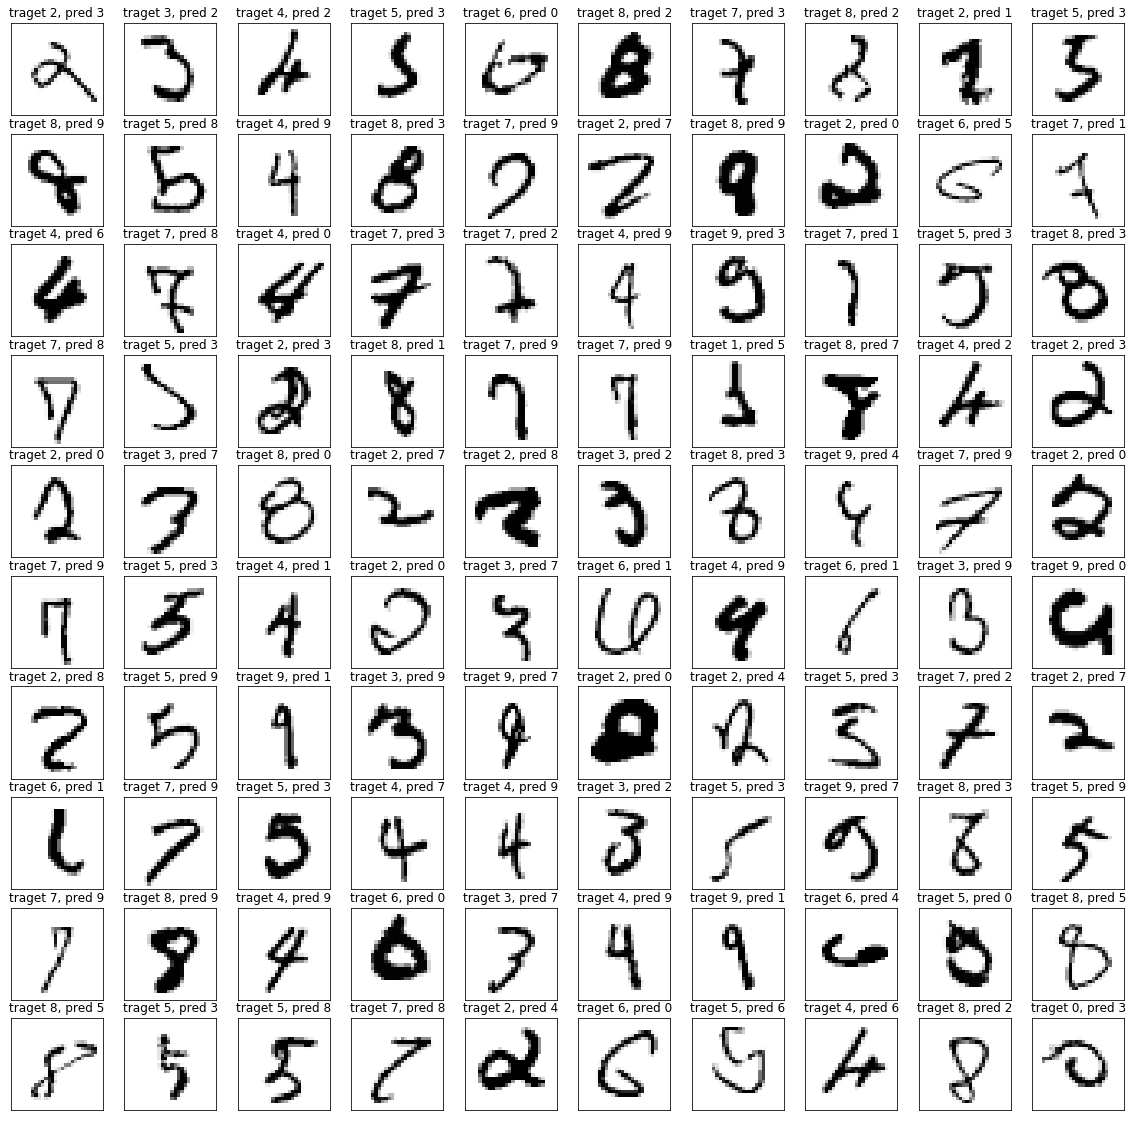

In [9]:
plt.figure()
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

# Indexes of incorrect predictions 
wrong_indexes = [i for i, item in enumerate(correct_prediction) if item == False]

for i, ax in enumerate(axes.flatten()): 
    
    single_prediction = torch.argmax(prediction[wrong_indexes[i]])
    single_data = x_test[wrong_indexes[i]].view(28, 28)
    single_target = y_test[wrong_indexes[i]]
    
    title = "traget {}, pred {}".format(single_target.item(), single_prediction.item())
    
    ax.imshow(single_data.to('cpu'), cmap="Greys")
    ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([])